In [ ]:
import numpy as np  

In [2]:
from scipy.optimize import curve_fit

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

In [4]:
import itertools

In [5]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [6]:
import mdtraj as md

# Dilute boxes

In [101]:
data = np.loadtxt("data/argon_n50_L20_T50_prod.csv", delimiter=',')

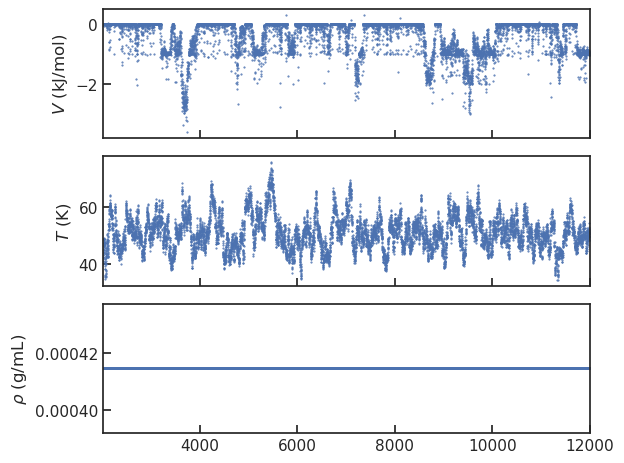

In [102]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
ax[0].plot(data[:,0], data[:,1], '.', ms=1)
#ax[0].set_ylim(-30000,200)
ax[0].set_ylabel(r'$V$ (kJ/mol)')

ax[1].plot(data[:,0], data[:,2], '.', ms=1)
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')

ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

In [167]:
traj = md.load_dcd("data/argon_n50_L20_T30_prod.dcd", top="data/argon_n50_L20_T50_min.pdb", stride=1)

In [168]:
bins, g_r = md.compute_rdf(traj, list(itertools.combinations(range(50), 2)), \
                               r_range=[0,1.5], n_bins=100)

/tmp/ipykernel_156839/4148210582.py:4: RuntimeWarning: divide by zero encountered in log
  axt.plot(bins, -np.log(g_r), color='C1')


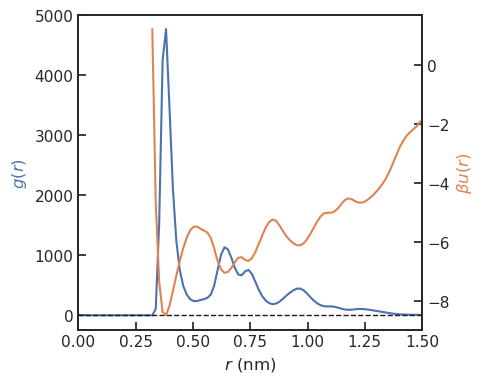

In [169]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(bins, g_r)
axt = ax.twinx()
axt.plot(bins, -np.log(g_r), color='C1')
ax.axhline(1,0,2,ls='dashed', lw=1, color='k')
ax.set_xlim(0.0,1.5)
ax.set_xlabel('$r$ (nm)')
ax.set_ylabel(r'$g(r)$', color='C0')
axt.set_ylabel(r'$\beta u(r)$', color='C1')
plt.tight_layout()

In [170]:
distances = md.compute_distances(traj, \
                                atom_pairs=list(itertools.combinations(range(20), 2)))

In [126]:
ldist = len(list(itertools.combinations(range(20), 2)))

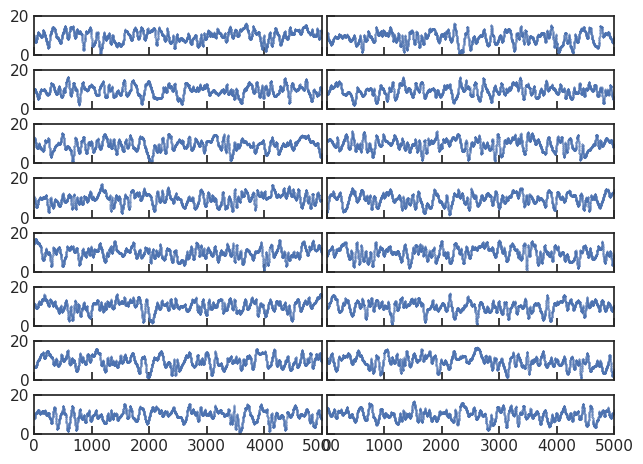

In [129]:
fig, ax = plt.subplots(8,2, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(ldist)[:16]:
    ax[i].plot(traj.time, distances[:,i], '.', ms=0.5)
ax[i].set_xlim(0,5000); ax[i].set_ylim(0,20)
plt.tight_layout(w_pad=0, h_pad=0)

In [136]:
nbins = 200
hist, bin_edges = np.histogram(np.concatenate(distances), density=True, bins=np.linspace(0,20,nbins))
bin_centers = np.array([0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(nbins-1)])

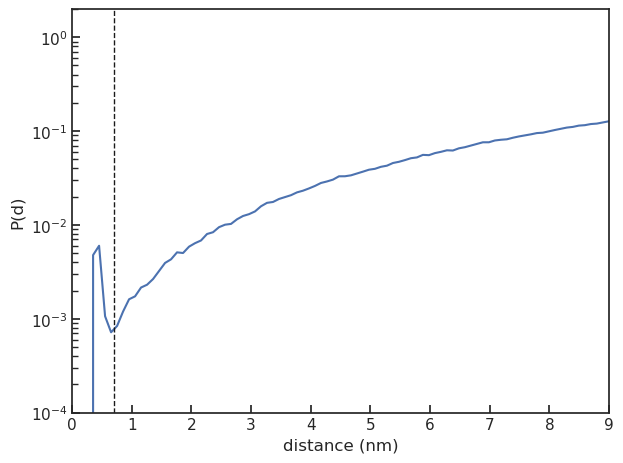

In [141]:
fig, ax = plt.subplots()
ax.plot(bin_centers, hist)
ax.axvline(0.7,0,1, ls='dashed', color='k', lw=1)
ax.set_xlabel('distance (nm)')
ax.set_ylabel('P(d)')
ax.set_yscale('log')
ax.set_ylim(1e-4,2); ax.set_xlim(0,9)
plt.tight_layout()

In [ ]:
ibound = np.argmin(np.abs(bin_centers - 0.7))
pb = np.trapz(hist[:ibound], dx=bin_centers[1]-bin_centers[0])
print ('Population bound = %.3e'%pb)

Population bound = 1.136e-03


dcdplugin) Could not access file 'data/argon_n50_L20_T70_prod.dcd'.


OSError: Could not open file: data/argon_n50_L20_T70_prod.dcd

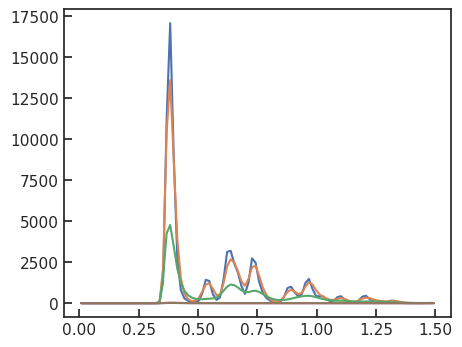

In [166]:
temps = range(10,160,10)
pb = []

fig, ax = plt.subplots(figsize=(5,4))
for t in temps:
    traj = md.load_dcd("data/argon_n50_L20_T%g_prod.dcd"%t, top="data/argon_n50_L20_T50_min.pdb", stride=1)
    bins, g_r = md.compute_rdf(traj, list(itertools.combinations(range(50), 2)), \
                               r_range=[0,1.5], n_bins=100)
    ax.plot(bins, g_r, label='T=%g K'%t)

    distances = md.compute_distances(traj, \
                                atom_pairs=list(itertools.combinations(range(20), 2)))
    hist, bin_edges = np.histogram(np.concatenate(distances), density=True, bins=np.linspace(0,20,nbins))
    bin_centers = np.array([0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(nbins-1)])
    ibound = np.argmin(np.abs(bin_centers - 0.7))
    pb.append(np.trapz(hist[:ibound], dx=bin_centers[1]-bin_centers[0]))
ax.axhline(1,0,2,ls='dashed', lw=1, color='k')
ax.set_xlim(0.0,1.5)
ax.set_xlabel('$r$ (nm)')
ax.set_ylabel(r'$g(r)$')
plt.legend(loc=1,ncols=2, fontsize=10)

plt.tight_layout()



# Dense phases

In [146]:
system = "argon"

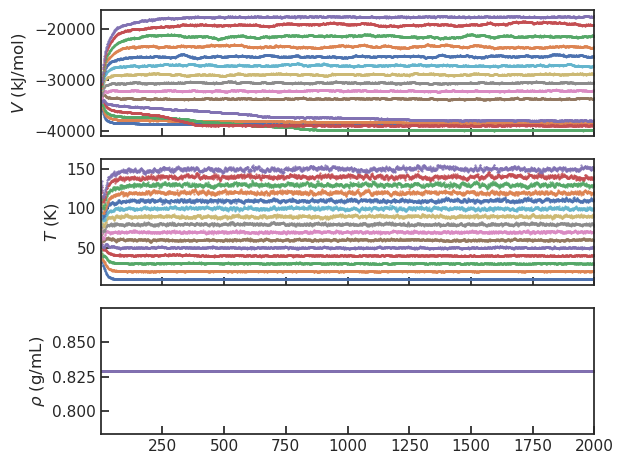

In [153]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
for t in range(10,160,10):
    data = np.loadtxt("data/%s_slab_T%g_equil.csv"%(system,t), delimiter=',')
    ax[0].plot(data[:,0], data[:,1], '.', ms=1)
    #ax[0].set_ylim(-30000,200)
    ax[1].plot(data[:,0], data[:,2], '.', ms=1)
    ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[0].set_ylabel(r'$V$ (kJ/mol)')
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

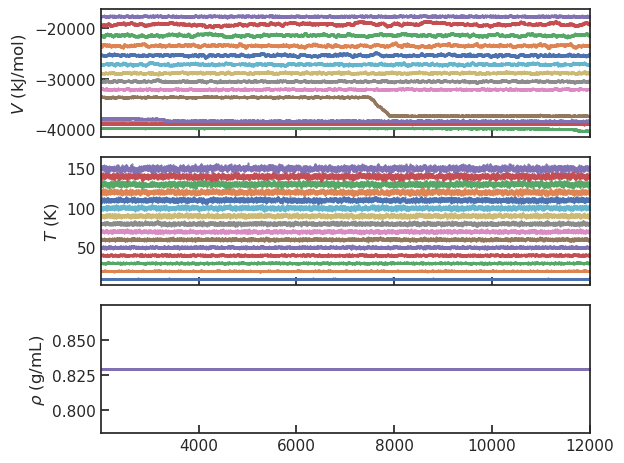

In [151]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
for t in range(10,160,10):
    data = np.loadtxt("data/%s_slab_T%g_prod.csv"%(system,t), delimiter=',')
    ax[0].plot(data[:,0], data[:,1], '.', ms=1)
    #ax[0].set_ylim(-30000,200)
    ax[1].plot(data[:,0], data[:,2], '.', ms=1)
    ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[0].set_ylabel(r'$V$ (kJ/mol)')
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

/tmp/ipykernel_156839/1053035411.py:7: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(bins, -np.log(g_r))


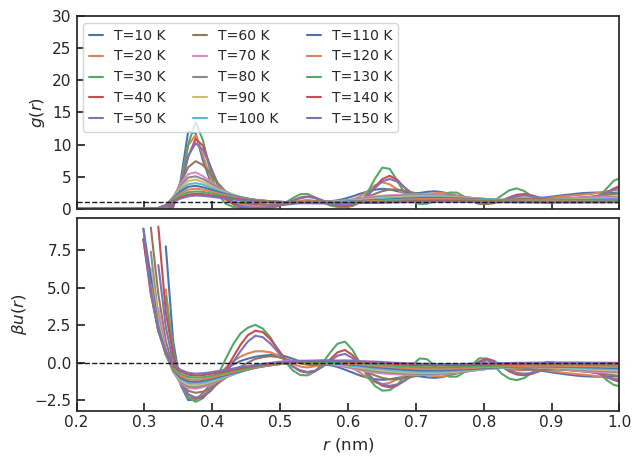

In [155]:
fig, ax = plt.subplots(2,1, sharex=True)
for t in range(10,160,10):
    traj = md.load_dcd("data/%s_slab_T%g_prod.dcd"%(system,t), top="data/%s_slab_T%g_min.pdb"%(system,t), stride=20)
    bins, g_r = md.compute_rdf(traj, list(itertools.combinations(range(1000), 2)), \
                               r_range=[0.15,1.25], n_bins=100)
    ax[0].plot(bins, g_r, label='T=%g K'%t)
    ax[1].plot(bins, -np.log(g_r))

ax[0].axhline(1,0,1,ls='dashed', lw=1, color='k')
ax[1].axhline(0,0,1,ls='dashed', lw=1, color='k')
ax[0].set_xlim(0.2,1)
ax[0].set_ylim(0,30)
ax[1].set_xlabel('$r$ (nm)')
ax[0].set_ylabel(r'$g(r)$')
ax[1].set_ylabel(r'$\beta u(r)$')
ax[0].legend(loc=2, fontsize=10, handlelength=1, ncols=3)
plt.tight_layout(h_pad=0)

In [156]:
def tanh_function(x, p0, p1, p2, p3):
    return p0 + p1*(np.tanh(p2-x) + (1 - np.tanh(p3-x)) + 1)/2 

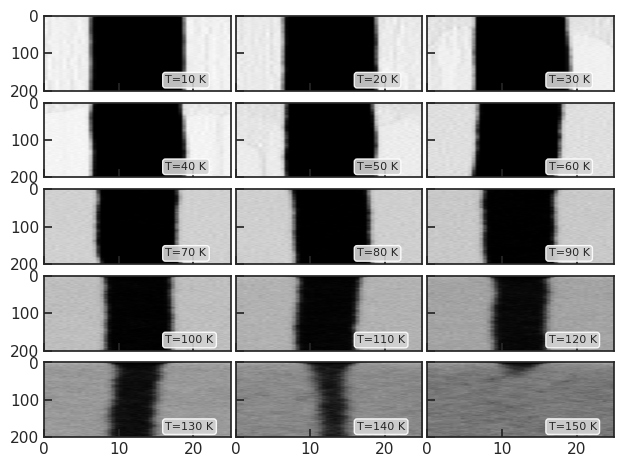

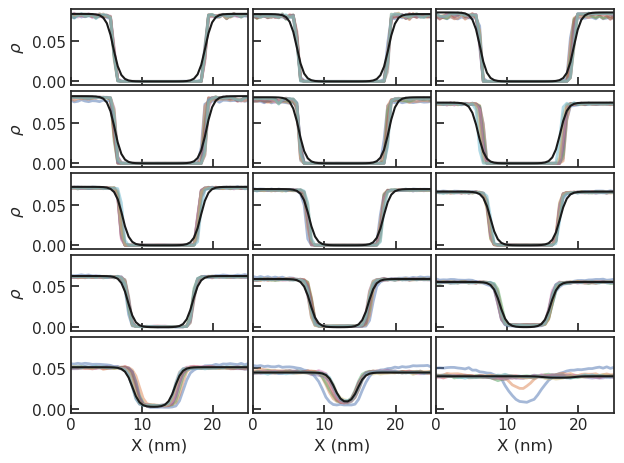

In [161]:
system = "argon" # ["neon", "argon", "krypton", "xenon"]:
temps = list(range(10, 160, 10))

fig, ax = plt.subplots(5,3, sharex=True, sharey=True)
fig2, ax2 = plt.subplots(5,3, sharex=True, sharey=True)

rho_vals = []

ax = ax.flatten()
ax2 = ax2.flatten()
for i,t in enumerate(temps):
    traj = md.load_dcd("data/%s_slab_T%g_equil.dcd"%(system,t), top="data/%s_slab_T%g_min.pdb"%(system,t), stride=10)
    hists = np.array([np.histogram(traj.xyz[i,:,0], bins=np.linspace(0,25,51), \
                                   density=True)[0] for i in range(traj.n_frames)])
    ax[i].imshow(hists, extent=[0,25, 200, 0],  aspect=0.05, cmap='binary_r', origin='upper')
    ax[i].text(0.65,0.1,'T=%g K'%t, transform=ax[i].transAxes, fontsize=8, \
               bbox=dict(facecolor='lightgray', alpha=0.9, boxstyle='round', pad=0.25))
    
    [ax2[i].plot(x, np.mean(hists[k*20:(k+1)*20], axis=0), lw=2, alpha=0.5) for k in range(10)]
    popt, pcov = curve_fit(tanh_function, x, np.mean(hists[-20:], axis=0), p0=p0, bounds=[0., [0.3, 0.3, 25, 25]])
    #print ("rho_a=%.2e; rho_b=%.2e"%(popt[0], popt[1]+popt[0]))
    rho_vals.append([popt[0], popt[1]+popt[0]])
    ax2[i].plot(x, tanh_function(x, *popt), label='$p_{opt}$', color='k')

[ax2[-i-1].set_xlabel('X (nm)') for i in range(3)]
[ax2[i*3].set_ylabel(r'$\rho$') for i in range(4)]
ax2[0].set_xlim(0,25)
fig.tight_layout(w_pad=0, h_pad=0)
fig2.tight_layout(w_pad=0, h_pad=0)

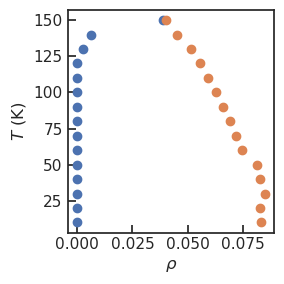

In [160]:
plt.subplots(figsize=(3,3))
plt.plot([x[0] for x in rho_vals], temps, 'o')
plt.plot([x[1] for x in rho_vals], temps, 'o')
plt.xlabel(r'$\rho$')
plt.ylabel('$T$ (K)')
plt.tight_layout()